# Part 1. Notebook for Network and Topological Analysis in Neuroscience

Authors: Eduarda Centeno & Fernando Santos

With this notebook, we would like to facilitate the computation of different metrics in Network and Topological analysis in neuroscience. Our goal is to cover both standard Graph Theory and a few Topological & Geometric data analysis metrics.

We will not include any step regarding preprocessing of imaging data. The resting state fMRI (rsfMRI) matrices used here (i.e., based in correlation values of time series) were obtained from the [The UCLA multimodal connectivity database](http://umcd.humanconnectomeproject.org/) (1000_Functional_Connectomes dataset - references [1-2]). Nevertheless, one can adapt and use the scripts here provided to networks based in other imaging modalities.

## Table of contents
1. [Imports](#imports)
2. [Importing data & the connectivity matrix](#importing-data)
3. [Graph Theory](#graph-theory)
4. [Topology & Geometry](#TDA)
5. [References](#references)
6. [Acknowledgements](#acknowledgements)

<a id='imports'></a>
###  **1.** Imports
#### Let's start with the necessary packages for the following computations: 

In [1]:
# Basic data manipulation and visualisation libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Magic command to change plotting backend
#%matplotlib qt

# Magic command to load watermark
%load_ext watermark

C:\Users\Mohsen\mambaforge\envs\graph\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [3]:
# Print versions
%watermark --author "Eduarda & Fernando" --date --time --python --machine --iversion --watermark --packages community,meshio,plotly,scipy,scikit-learn,jupyterlab,notebook

Author: Eduarda & Fernando

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

community   : 0.15
meshio      : 5.3.4
plotly      : 5.11.0
scipy       : 1.10.0
scikit-learn: 1.2.0
jupyterlab  : 3.5.2
notebook    : 6.5.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 8 Stepping 2, AuthenticAMD
CPU cores   : 32
Architecture: 64bit

sys       : 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:41:22) [MSC v.1929 64 bit (AMD64)]
pandas    : 1.5.2
networkx  : 2.8.8
numpy     : 1.24.1
gudhi     : 3.7.0
community : 0.15
seaborn   : 0.12.2
matplotlib: 3.6.2

Watermark: 2.3.1



<a id='importing-data'></a>
### **2.** Importing data & the connectivity matrix
#### Now we will start working with the brain data. 
Here, we will try to cover both computation and some theoretical background/key points on each section. 
Our first step will be on how to import the matrix data:

In [4]:
matrix = np.genfromtxt('./1000_Functional_Connectomes/Connectivity matrices/AveragedMatrix.txt')

In [5]:
matrix.shape

(177, 177)

##################################################################################################
##### **Here we'll make available the computation on how to compute the average matrix, but to make it faster, we'll work with the file that we already saved.**
The idea here is to get an average matrix from all matrices available. For that, different methods can be used. We'll show two common ones: one with pandas, another with Numpy. 

In [ ]:
# Importing all matrices to generate averaged data with Numpy or Pandas
matrices = [np.genfromtxt(file) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]
matricesP = [pd.read_csv(file, header = None, delim_whitespace=True) for file in glob.glob('./1000_Functional_Connectomes/Connectivity matrices/*_matrix_file.txt')]

# Averaging matrices with Numpy
MatAv = np.zeros(shape=matrices[0].shape)
for matrix in matrices:
    MatAv += matrix

matrix = MatAv/len(matrices)

# Averaging matrices with Pandas
Pdmatrix = pd.concat(matricesP).groupby(level=0).mean()

##################################################################################################

#####  **Let´s obtain the region names and subnetwork information**

In [ ]:
# Obtaining name of areas according to matching file
lineList = [line.rstrip('\n') for line in open('./1000_Functional_Connectomes/Region Names/Baltimore_5560_region_names_abbrev_file.txt')]

# Obtaining a random list of numbers to simulate subnetworks -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
sublist = [line.rstrip('\n') for line in open('./subnet_ordernames.txt')]

# Obtaining a random list of colors that will match the random subnetwork classification for further graphs -- THESE COLORNAMES DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colorlist = [line.rstrip('\n') for line in open('./subnet_order_colors.txt')]

# Obtaining a random list of colors (in numbers) that will match the random subnetwork classification for further graphs -- THESE NUMBERS DO NOT CORRESPOND TO ANY REAL CLASSIFICATION
colornumbs = np.genfromtxt('./subnet_colors_number.txt')

#####  **Important!!**
Have a look at the following files to check if they match your matrix's regions/subnets. If not, you will have to create your own files:

    a. *_region_names_abbrev.txt
    b. *_region_names_full_file.txt
    c. subnet_colors_number.txt
    d. subnet_ordernames.txt
    e. subnet_order_colors.txt
    f. HCP_positions.txt
    
If you are working with matrices that had regions removed (low signal, tumor mask, etc.), you will have to adapt the notebook (or the base files) to take that into account. We provide code snippet (removing_regions.py in Background Scripts) which will help you with that. How to proceed (2 options): 

    a. You can just copy the function in removing_regions.py (starting at ln 22) and paste it under this cell. That will allow you to correct ineList, sublist, colorlist, colornumbs according to the regions that should be removed.
    b. If the same regions were removed for all your matrices, you can also just correct the files listed above and erase the regions you won't use.
    c. For 2-visualization_3d.ipynb visualizations, we are adapting the functions to accept option (a) (Not ready yet). However, if you choose to proceed with (b), this will also work for 2-visualization_3d.ipynb, since the chages will be in the base files (which are called by HCP_Data_Vis.py)
    
*Important*: the final lineList, sublist, colorlist, colornumbs must have the same length as your matrix!

##################################################################################################

#### Now, let's use Seaborn's heatmap to plot correlation matrix:
After importing the matrix, we can start with a standard representation - heatmaps!

In [ ]:
# Creating a DataFrame which will have the rows and column names according to the brain areas
matrixdiagNaN = matrix.copy()
np.fill_diagonal(matrixdiagNaN,np.nan)
Pdmatrix = pd.DataFrame(matrixdiagNaN)
Pdmatrix.columns = lineList
Pdmatrix.index = lineList
Pdmatrix = Pdmatrix.sort_index(0).sort_index(1)

##### Here is our Heatmap!

In [ ]:
# This mask variable gives you the possibility to plot only half of the correlation matrix. 
mask = np.zeros_like(Pdmatrix.values, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

plt.figure(figsize = (20, 20))
_ = sns.heatmap(Pdmatrix, cmap='coolwarm', cbar=True, square=False, mask=None) # To apply the mask, change to mask=mask

##### **Key point:**
When working with network analysis in brain data, a couple of crucial decisions have to be made.
For example, one can decide to use all network connections - including low-weight links (sometimes considered spurious connections), or establish an arbitrary threshold and keep only links above a specific correlation value. This step can be done in different ways, based solely on the correlation threshold (as done here), or based on network density (i.e., you keep only the 20% strongest correlations). 
If using an arbitrary threshold, it is also possible to define if the resulting matrix will be weighted (i.e., keeping the edges' weight), or unweighted (binarised matrices).

Another point of discussion is how to deal with negative weights in weighted networks. A common practice is to absolutise the matrix and preserve the topology. This approach also facilitates the computation of several metrics from graph theory that are not adapted for negative weights.
Here, we have chosen to proceed by using the absolute of all connections in the correlation matrix.

*We strongly suggest Reference [3] for a deeper understanding on all these decisions.*

Figure 1 provides a schematic summary of the types of networks:

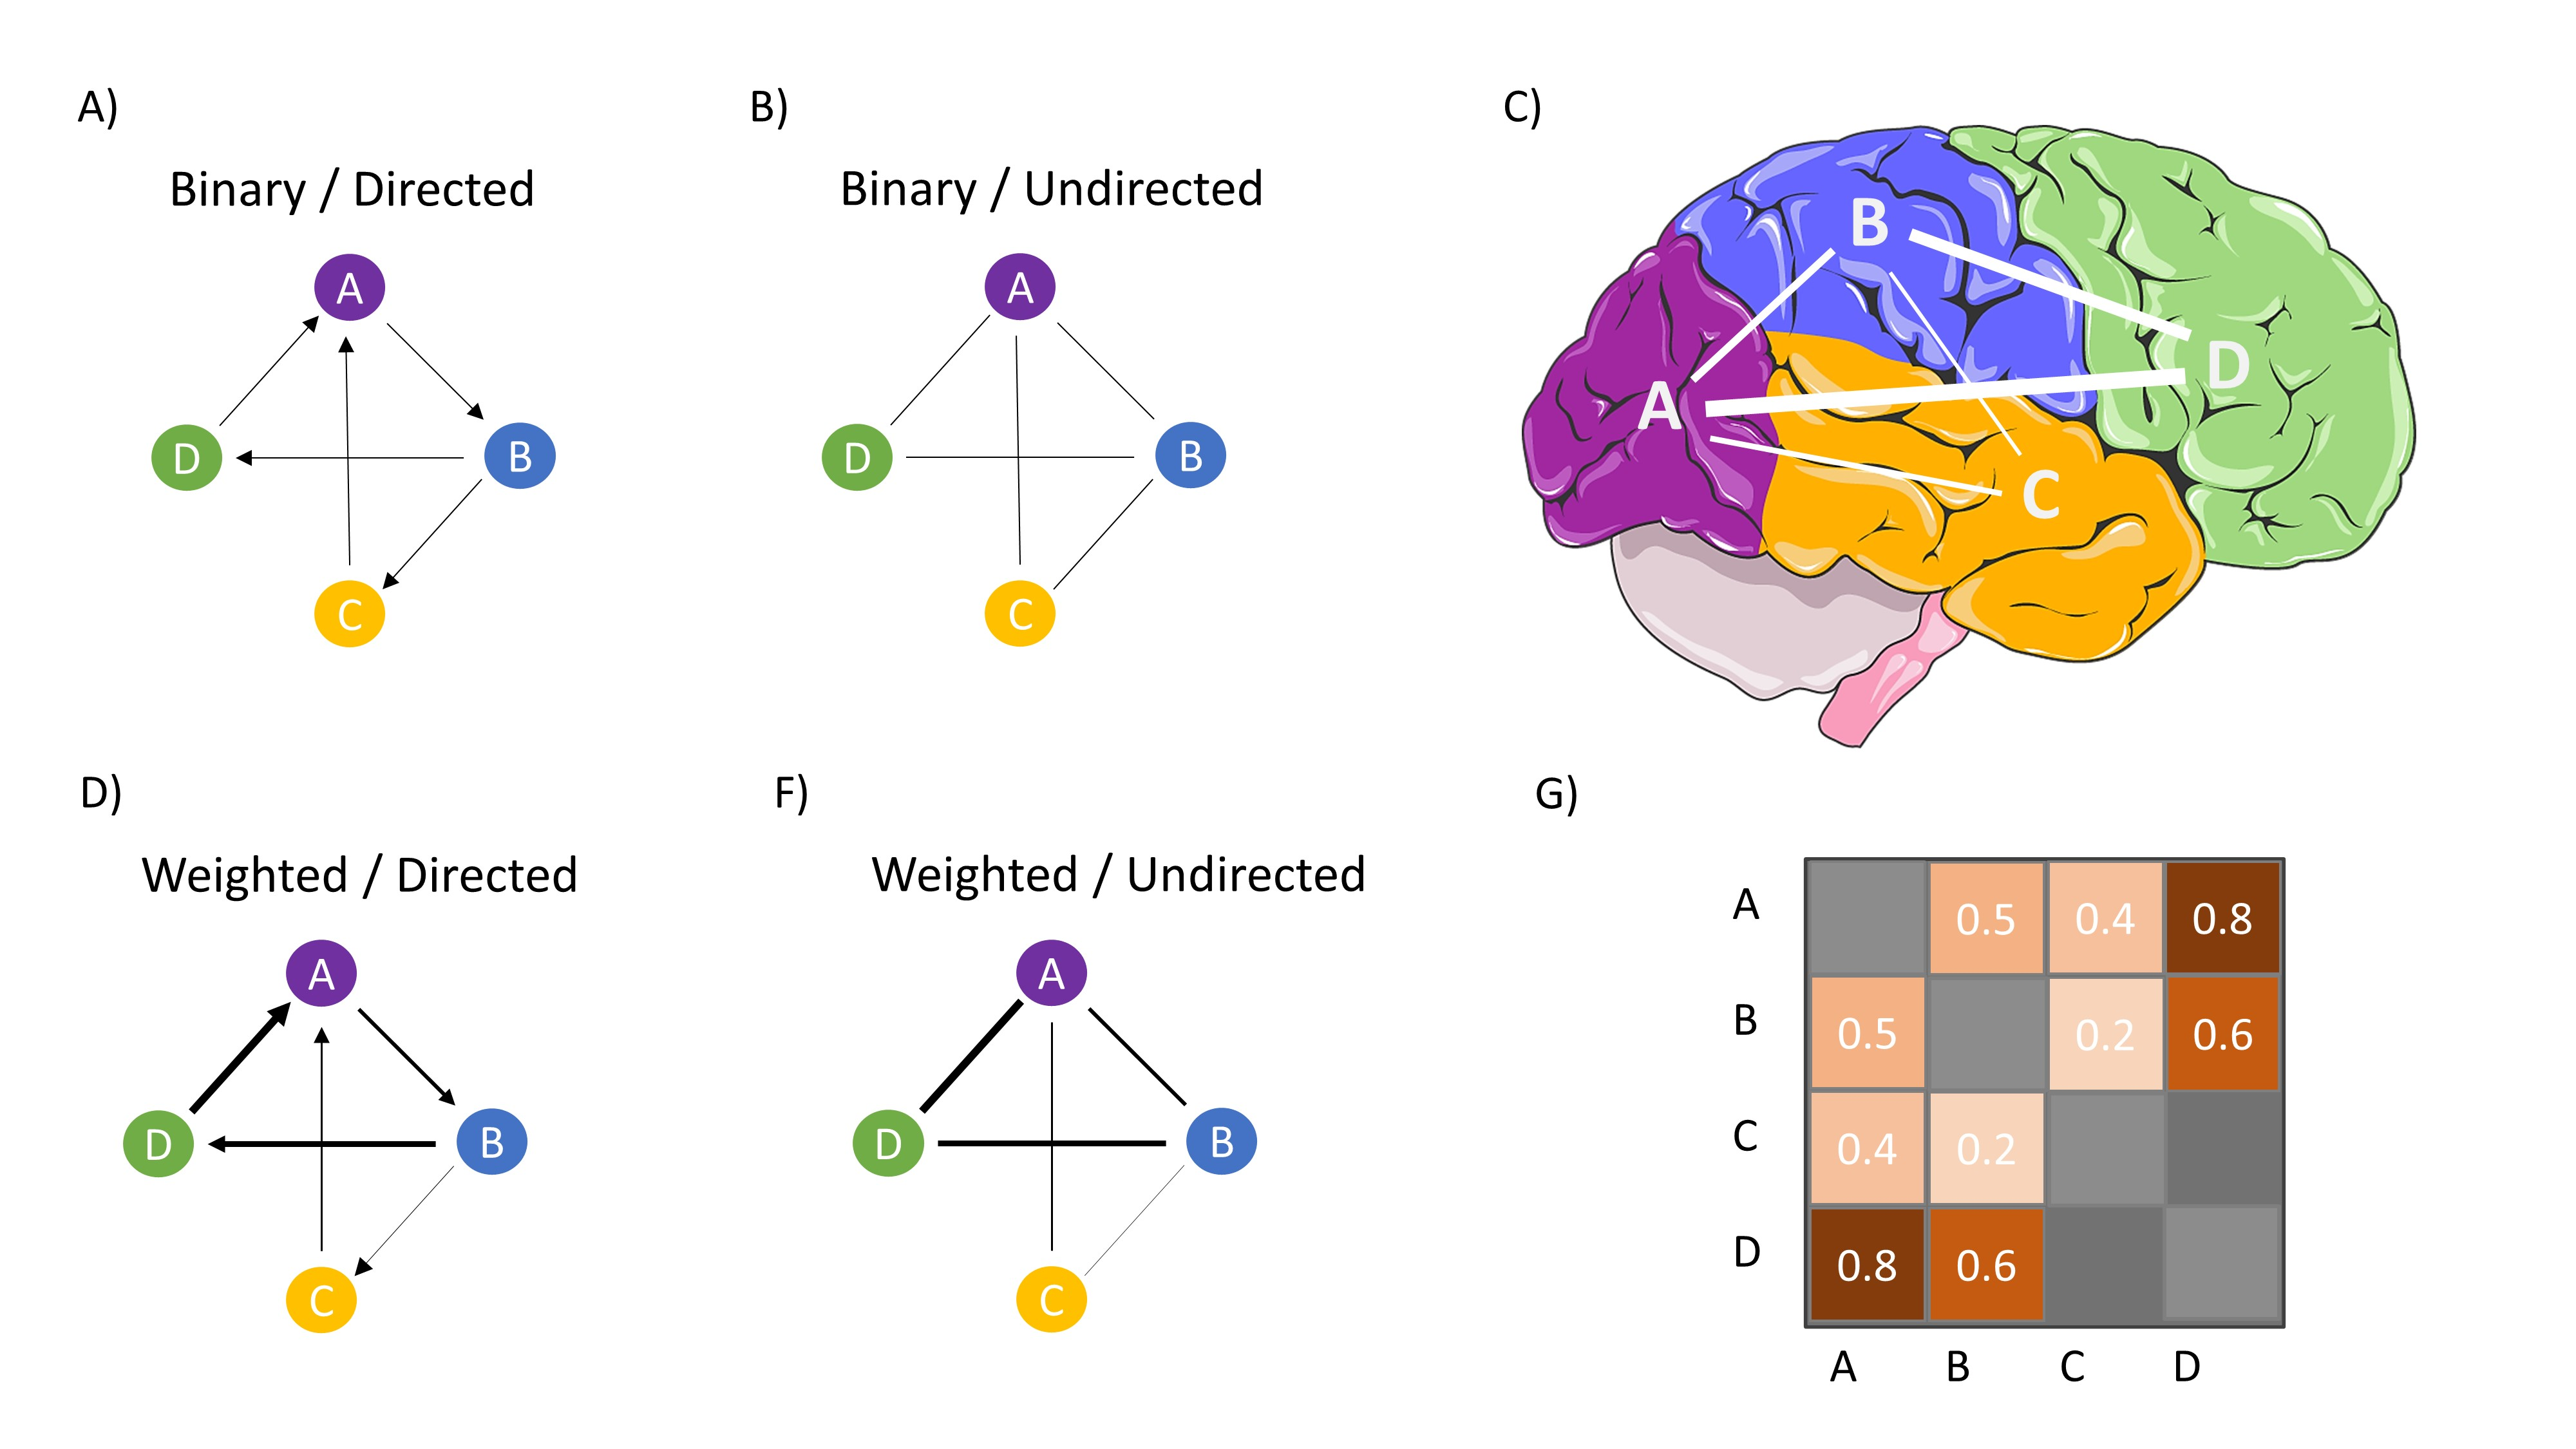

Figure 1. Types of networks. (A) A binary directed graph. (B) Binary, undirected graph. In binary graphs, the presence of a connection is signified by a 1 or 0 otherwise. (C) A representation of graph F as a network of brain areas. (D) A weighted, directed graph. (F) A weighted, undirected graph. In a weighted graph, the strength of the connections is represented by a number [0,1]. (G) A connectivity matrix of C and F. Source: Part of the image was obtained from [Smart Servier Medical Art](https://smart.servier.com/).

In [ ]:
# Absolutise for further user
matrix = abs(matrix)
matrixdiagNaN = abs(matrixdiagNaN)

##### **Key point:**
When working with fMRI brain network data, it is useful to generate some plots (e.g., the heatmaps above for matrix visualisation, and distribution plots of edge weights) to facilitate data comprehension and flag potential artefacts. In brain networks, we expect mostly weak edges and a smaller proportion of strong ones. When plotted as a probability density of log10, we expect the weight distribution to have a Gaussian-like form [3].

In [ ]:
# Weight distribution plot
bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Distribution of raw weights
rawdist = sns.distplot(matrixdiagNaN.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

# Probability density of log10
log10dist = sns.distplot(np.log10(matrixdiagNaN).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

<a id='graph-theory'></a>
### **3.**  Graph Theory 
#### From now, we will start working with some standard Graph Theory metrics.
The metrics that we will cover here are:
- Density
- Degree/Strength -  *the word degree is commonly used for binary graphs, whereas strength tends to be used for weighted networks. (Reference [1] - Chapter 4)*
- Centrality: Eigenvector, Betweenness, Closeness, Degree, Page Rank
- Path length
- Modularity
- Assortativity
- Clustering coefficient

##### **Key point:**
Each of these metrics has its requisites for computation. For example, it is not possible to accurately compute closeness centrality and the average shortest path for fragmented networks (i.e., there are subsets of disconnected nodes). Therefore, keep that in mind when thinking about thresholding a matrix.

Figure 2 provides a summary of some graph-theoretical metrics:

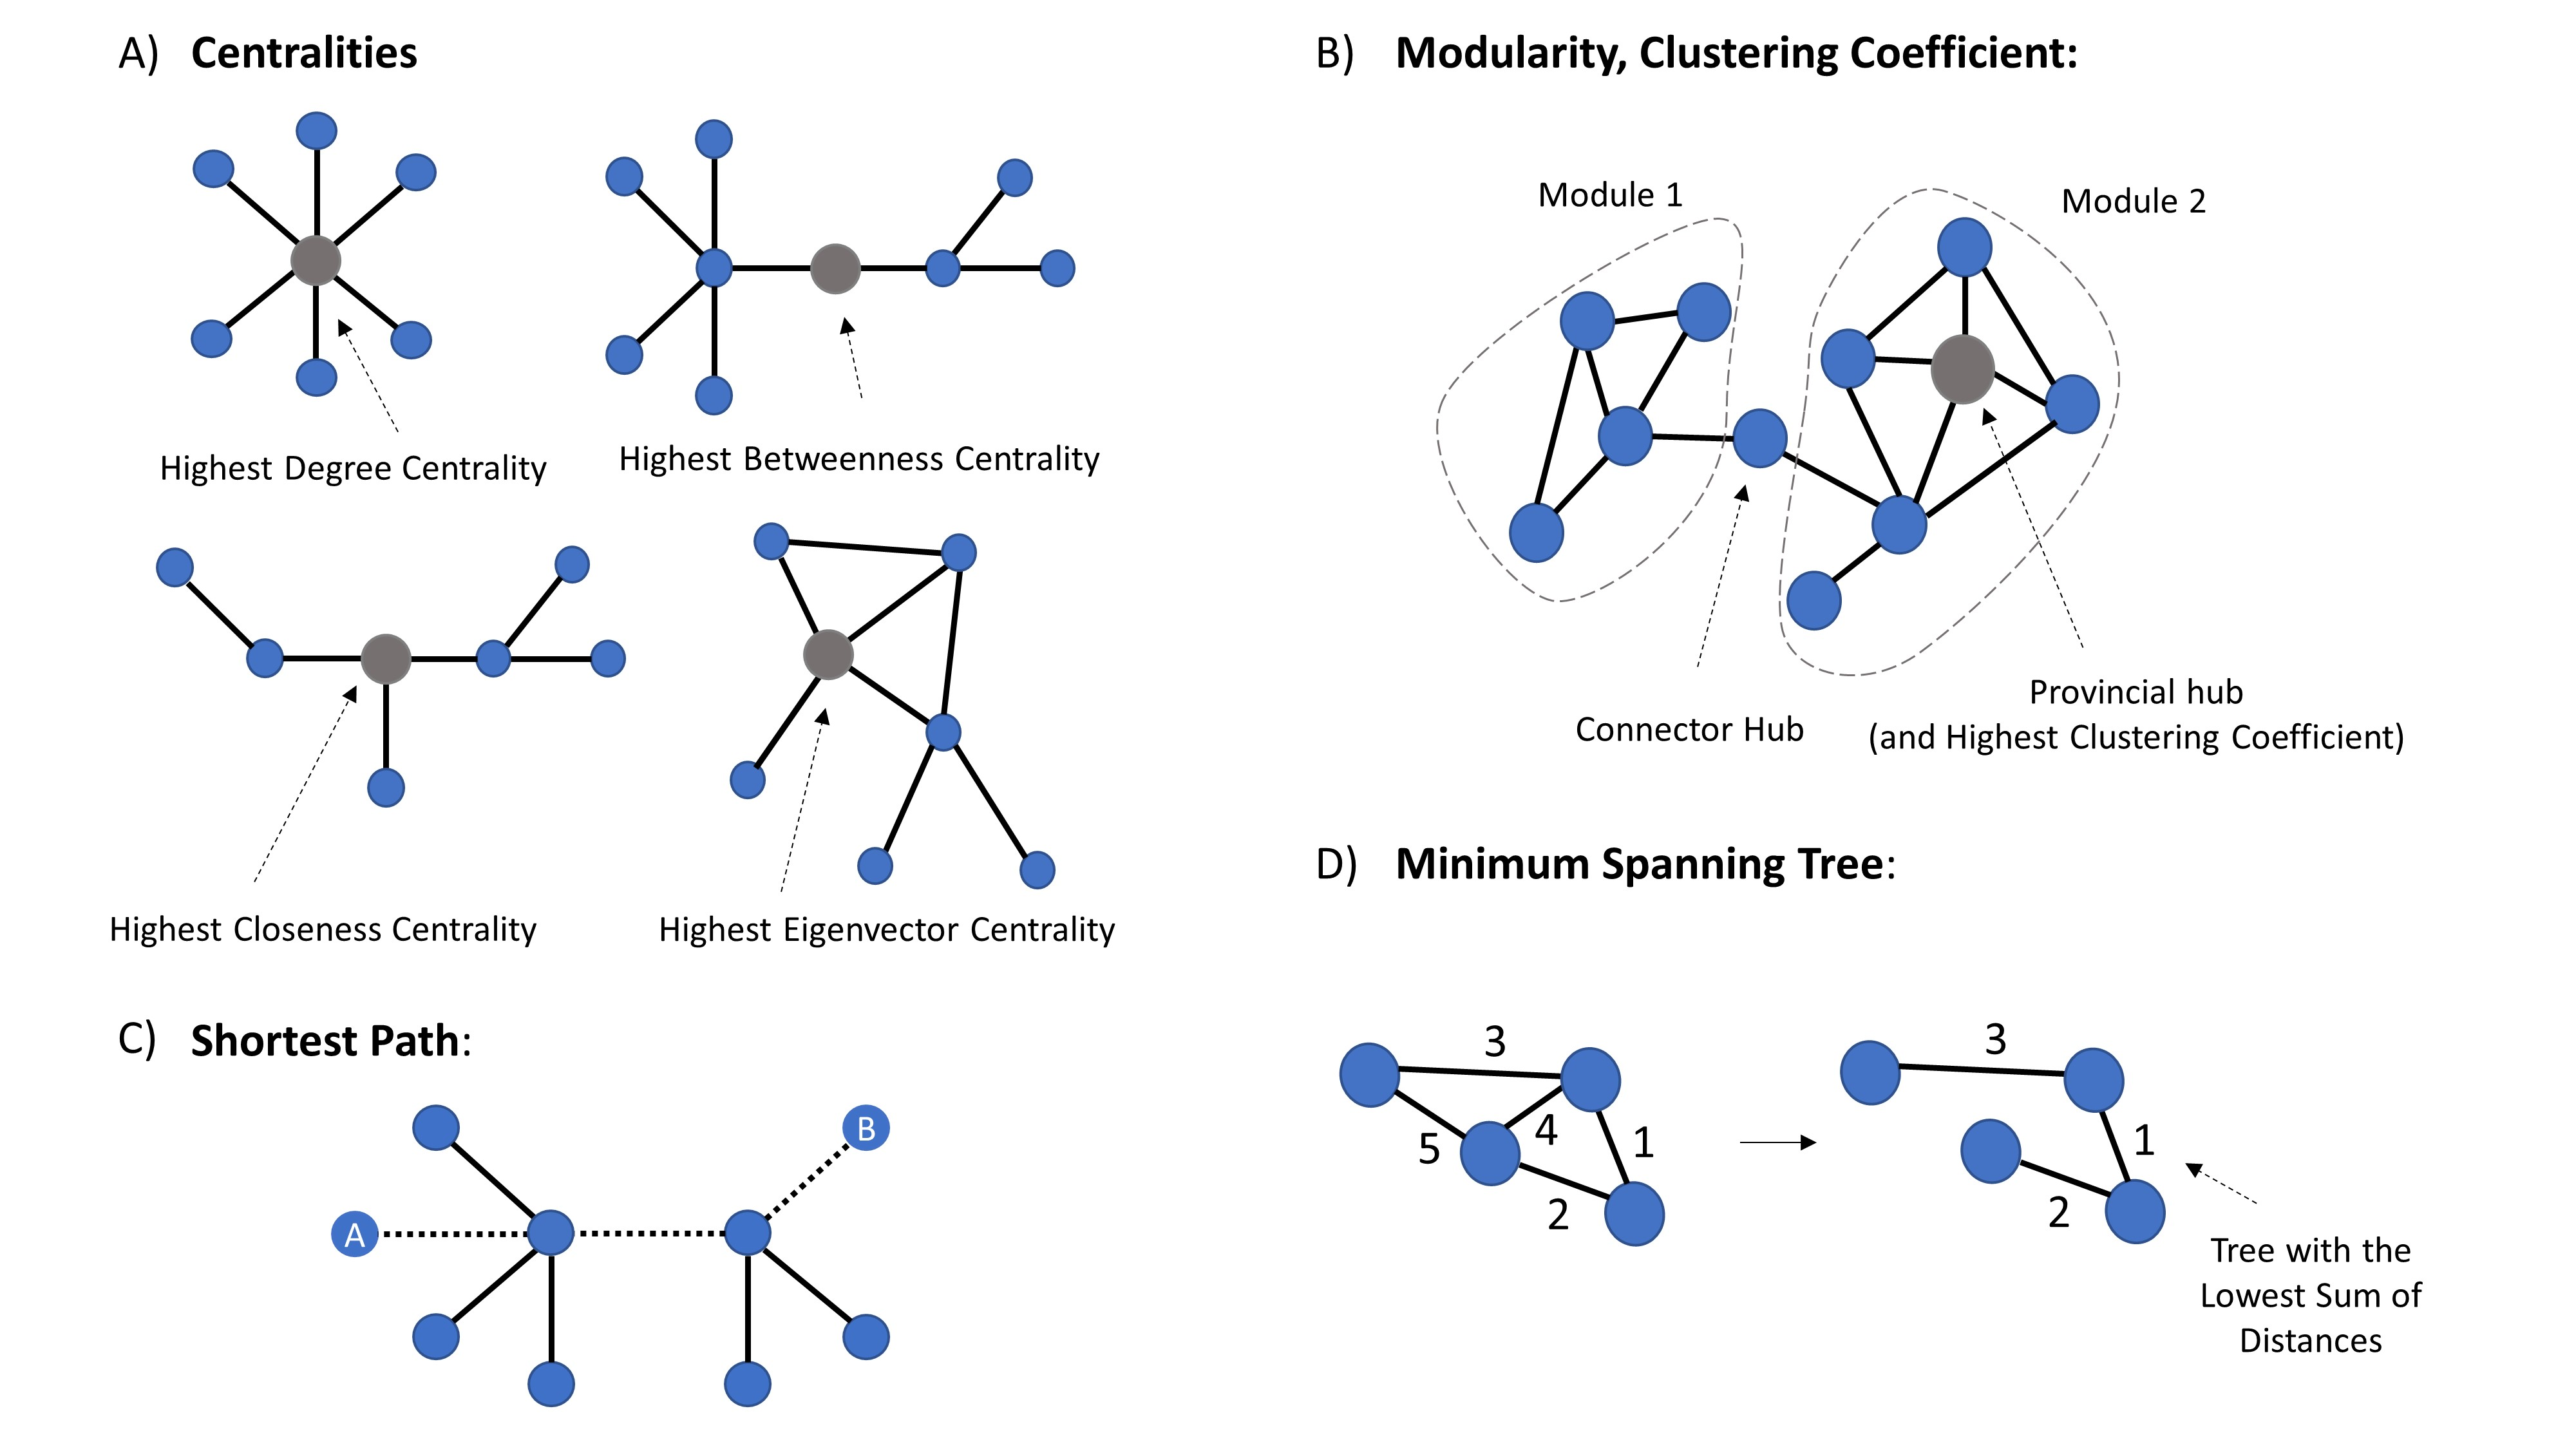
Figure 2. Graph theoretical metrics. (A) A representation of a graph indicating centralities. (B) Representation of modularity and clustering coefficient. (C) The shortest path between vertices A and B. (D) The minimum spanning tree.

##### We will start by creating the graph and removing its self-loops (i.e., a connection of a node with itself).

In [ ]:
# Creating a graph
G = nx.from_numpy_matrix(matrix)

# Removing self-loops
G.remove_edges_from(list(nx.selfloop_edges(G)))

##### Now, we compute the network's density.


<u>Definition</u>:
 A graph's density is the ratio between the number of edges and the total number of possible edges. 

Clearly, in all-to-all connected graphs, the density will be maximal (or 1), whereas for a graph without edges it will be 0. Here, just for the sake of demonstration, we will compute the density of different states of the network to show how density changes.

In [ ]:
#print(nx.density.__doc__)

# Create graphs for comparison
matrix2 = matrix.copy()
matrix3 = matrix.copy()

# Create sparser graphs
matrix2[matrix2<=0.50] = 0
matrix3[matrix3<=0.75] = 0

st50G = nx.from_numpy_matrix(matrix2)
st25G = nx.from_numpy_matrix(matrix3)

st50G.remove_edges_from(list(nx.selfloop_edges(st50G)))
st25G.remove_edges_from(list(nx.selfloop_edges(st25G)))

# Compute densities
alltoall = nx.density(G)
st50 = nx.density(st50G)
st25 = nx.density(st25G)

names = ['All-To-All', '> 0.5', '> 0.75']
values = [alltoall, st50, st25]

dict(zip(names, values))

##### Now, we compute the nodal degree/strength.

<u>Definition</u>: In undirected weighted networks the node strength can be computed as the sum of the connectivity weights of the edges attached to each node. It is a primary metric to identify how important is a node in the graph. 
It is possible to apply a normalization (divide the weights by 1/N-1) to make the output value more intuitive. (Reference [3] pg. 119)  

In degree computation, it is also common to compute the mean degree of the network, which is the sum of node degrees divides by the total number of nodes.

In [ ]:
# Computation of nodal degree/strength
#print(nx.degree.__doc__)

strength = G.degree(weight='weight')
strengths = {node: val for (node, val) in strength}
nx.set_node_attributes(G, dict(strength), 'strength') # Add as nodal attribute

# Normalized node strength values 1/N-1
normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
nx.set_node_attributes(G, normstrenghts, 'strengthnorm') # Add as nodal attribute

# Computing the mean degree of the network
normstrengthlist = np.array([val * 1/(len(G.nodes)-1) for (node, val) in strength])
mean_degree = np.sum(normstrengthlist)/len(G.nodes)
print(mean_degree)

##### Next, we will compute the centralities!

Centralities are frequently used to understand which nodes occupy critical positions in the network.

Remember: 
- Degree Centrality: The degree centrality for a node **v** is the fraction of nodes it is connected to. This metric is the same as node degree, so it will not be computed again. (NetworkX Documentation [4])

- Closeness Centrality: In weighted graphs, the closeness centrality of a node __v__ is the reciprocal of the sum of the shortest weighted path distances from **v** to all *N-1* other nodes. An important thing to think about this metric is that a node with many low weight edges can have the same centrality as a node with only a few high-weighted edges. (NetworkX Documentation, Reference [3] - Chapter 5)

- Betweenness Centrality: Betweenness centrality of a node **v** is the sum of the fraction of all-pairs shortest paths that pass through __v__. (NetworkX Documentation [4]) 

- Eigenvector Centrality: Eigenvector centrality computes the centrality for a node based on its neighbours' centrality. It takes into account not only quantity (e.g., degree centrality) but also quality. If a node is linked to many nodes that also display a high degree, that node will have high eigenvector centrality. (NetworkX Documentation)

- Page Rank: PageRank computes a ranking of the nodes in the graph G based on the incoming links' structure. (NetworkX Documentation [4])

In [ ]:
# Closeness centrality
#print(nx.closeness_centrality.__doc__)

# The function accepts a argument 'distance' that, in correlation-based networks, must be seen as the inverse ... 
# of the weight value. Thus, a high correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data='weight')}

# Then add them as attributes to the graph edges
nx.set_edge_attributes(G, G_distance_dict, 'distance')

# Computation of Closeness Centrality
closeness = nx.closeness_centrality(G, distance='distance')

# Now we add the closeness centrality value as an attribute to the nodes
nx.set_node_attributes(G, closeness, 'closecent')

# Visualise  values directly
#print(closeness)

# Closeness Centrality Histogram
sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Betweenness centrality:
#print(nx.betweenness_centrality.__doc__)
betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True) 
                                                                
# Now we add the it as an attribute to the nodes
#nx.set_node_attributes(G, betweenness, 'bc')

# Visualise  values directly
#print(betweenness)

# Betweenness centrality Histogram
sns.distplot(list(betweenness.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Eigenvector centrality
#print(nx.eigenvector_centrality.__doc__)
eigen = nx.eigenvector_centrality(G, weight='weight')

# Now we add the it as an attribute to the nodes
nx.set_node_attributes(G, eigen, 'eigen')

# Visualise  values directly
#print(eigen)

# Eigenvector centrality Histogram
sns.distplot(list(eigen.values()), kde=False, norm_hist=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Page Rank
#print(nx.pagerank.__doc__)
pagerank = nx.pagerank(G, weight='weight')

# Add as attribute to nodes
nx.set_node_attributes(G, pagerank, 'pg')

# Visualise values directly
#print(pagerank)

# Page Rank Histogram
sns.distplot(list(pagerank.values()), kde=False, norm_hist=False)
plt.xlabel('Pagerank Values')
plt.ylabel('Counts')

##### Now, let's move on to the Path Length!

- Shortest Path:  The shortest path (or distance) between two nodes in a graph. In a weighted graph it is obtained by the minimum sum of weights.

- Average Path Length: It is a concept in network topology that is defined as the average number of steps along the shortest paths for all possible pairs of network nodes. It is a measure of the efficiency of information or mass transport on a network.

In [ ]:
# Path Length
#print(nx.shortest_path_length.__doc__)

# This is a versatile version of the ones below in which one can define or not source and target. Remove the hashtag to use this version.
#list(nx.shortest_path_length(G, weight='distance'))

# This one can also be used if defining source and target: 
#print(nx.dijkstra_path_length.__doc__)
nx.dijkstra_path_length(G, source=20, target=25, weight='distance')

# Whereas this one is for all pairs. Remove the hashtag to use this version.
#print(nx.all_pairs_dijkstra_path_length.__doc__)
#list(nx.all_pairs_dijkstra_path_length(G, weight='distance'))

In [ ]:
# Average Path Length or Characteristic Path Length
#print(nx.average_shortest_path_length.__doc__)
nx.average_shortest_path_length(G, weight='distance')

##### Now, modularity, assortativity, clustering coefficient and the minimum spanning tree!

- Modularity: Modularity compares the number of edges inside a cluster with the expected number of edges that one would find if the network was connected randomly but with the same number of nodes and node degrees. It is used to identify strongly connected subsets, i.e., modules or 'communities'. Here, we will use the Louvain algorithm, as recommended in Reference [3].

- Assortativity: Assortativity measures the similarity of connections in the graph with respect to the node degree. (NetworkX)

- Clustering coefficient: a measure of the tendency for any two neighbours of a node to be directly connected. According to Networkx's documentation, weighted graphs' clustering coefficient is defined as the geometric average of the subgraph edge weights. (NetworkX, Reference [4])

- Minimum Spanning Tree: it is the backbone of a network, i.e. the minimum set of edges necessary to ensure that paths exist between all nodes. A few main algorithms are used to build the spanning tree, being the Kruskal's algorithm the one used by NetworkX. Briefly, this algorithm ranks the distance of the edges, adds the ones with the smallest distance first, and by adding edge-by-edge, it checks if cycles are formed or not. The algorithm will not add an edge that results in the formation of a cycle.

In [ ]:
# Modularity
#print(community.best_partition.__doc__)
#from community import best_partition
part = community.best_partition(G, weight='weight')

# Visualise values directly
#print(part)

# Check the number of communities
set(part.values()).union()

In [ ]:
# Assortativity
#print(nx.degree_pearson_correlation_coefficient.__doc__)
nx.degree_pearson_correlation_coefficient(G, weight='weight')

In [ ]:
# Clustering Coefficient
#print(nx.clustering.__doc__)
clustering = nx.clustering(G, weight='weight')

# Add as attribute to nodes
nx.set_node_attributes(G, clustering, 'cc')

# Visualise values directly
#print(clustering)

# Clustering Coefficient Histogram
sns.distplot(list(clustering.values()), kde=False, norm_hist=False)
plt.xlabel('Clustering Coefficient Values')
plt.ylabel('Counts')

In [ ]:
# Average Clustering Coefficient
#print(nx.clustering.__doc__)
nx.average_clustering(G, weight='weight')

In [ ]:
# Minimum Spanning Tree
GMST = nx.minimum_spanning_tree(G, weight='distance')

#### Data Visualisation & Graph Theory
Under this section we we'll provide a few ideas of how to visualise and present your network.

First, let's get some important attributes about brain area names and subnetworks. These will be used later for graphical visualisation!

In [ ]:
# Function to transform our list of brain areas into a dictionary
def Convert(lst): 
    res_dct = {i : lst[i] for i in range(0, len(lst))} 
    return res_dct

# Add brain areas as attribute of nodes
nx.set_node_attributes(G, Convert(lineList), 'area')

# Add node colors
nx.set_node_attributes(G, Convert(colorlist), 'color')

# Add subnetwork attribute
nx.set_node_attributes(G, Convert(sublist), 'subnet')

# Add node color numbers
nx.set_node_attributes(G, Convert(colornumbs), 'colornumb')

Now we will create a standard spring network plot, but this could also be made circular by changing to *draw_circular*.

We defined the edge widths to the power of 2 so that weak weights will have smaller widths.

In [ ]:
# Standard Network graph with nodes in proportion to Graph degrees
plt.figure(figsize=(30,30))
edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]
pos = nx.spring_layout(G, scale=5)
nx.draw(G, pos, with_labels=True, width=np.power(edgewidth, 2), edge_color='grey', node_size=normstrengthlist*20000, 
        labels=Convert(lineList), font_color='black', node_color=colornumbs/10, cmap=plt.cm.Spectral, alpha=0.7, font_size=9)
#plt.savefig('network.jpeg')

In [ ]:
# Let's visualise the Minimum Spanning Tree
plt.figure(figsize=(15,15))
nx.draw(GMST, with_labels=True, alpha=0.7, font_size=9)

* Detail! 
For the sake of a less overwhelming plot, we will work with the st50G graph for the CircosPlot.

In [ ]:
# First let's just add some attributes so that it becomes more interesting

nx.set_node_attributes(st50G, dict(st50G.degree(weight='weight')), 'strength')

nx.set_node_attributes(st50G, Convert(lineList), 'area')

nx.set_node_attributes(st50G, Convert(colorlist), 'color')

nx.set_node_attributes(st50G, Convert(sublist), 'subnet')

#edgecolors = {(e1, e2): int((weight+1)**3) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
#nx.set_edge_attributes(st50G, edgecolors, 'edgecolor')

G_distance_dict2 = {(e1, e2): 1 / abs(weight) for e1, e2, weight in st50G.edges(data='weight')}

# Then add them as attributes to the graph
nx.set_edge_attributes(st50G, G_distance_dict2, 'distance')


st50GRL = nx.relabel_nodes(st50G, {i: lineList[i] for i in range(len(lineList))})

# CircosPlot
circ = CircosPlot(st50GRL, figsize=(30,30), node_labels=True, node_label_layout='rotation', node_order='subnet',
                  edge_color='weight', edge_width='weight', node_color='subnet', node_label_color=True, fontsize=10, 
                  nodeprops={"radius": 2}, group_legend=True, group_label_offset=5)

circ.draw()

circ.sm.colorbar.remove()
labels_networks = sorted(list(set([list(circ.graph.nodes.values())[n][circ.node_color] for n in np.arange(len(circ.nodes))])))

plt.legend(handles=circ.legend_handles,
           title="Subnetwork",
           ncol=6,
           borderpad=1,
           shadow=True,
           fancybox=True,
           loc='best',
           fontsize=10,
           labels= labels_networks)

plt.show()

In [ ]:
# How to get node positions according to https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [ ]:
# Visualisation of Communities/Modularity - Run cells 135 and 137 before!
plt.figure(figsize=(25,25))
values = [part.get(node) for node in G.nodes()]
clust=[i*9000 for i in nx.clustering(G, weight='weight').values()]
nx.draw(G, pos=community_layout(G, part), font_size=8, node_size=clust, node_color=values, width=np.power([ d['weight'] for (u,v,d) in G.edges(data=True)],2), 
        with_labels=True, labels=Convert(lineList), font_color='black', edge_color='grey', cmap=plt.cm.Spectral, alpha=0.7)

<a id='TDA'></a>

## **4.** Topology & Geometry
#### Moving on to Topology & Geometry metrics.

Here, we will cover a few computations that are being applied in Neuroscience:
- Persistent Homology
- Euler Characteristic and Curvature

#####  Let's start with persistent homology computations: 
Persistent homology is a method for computing topological features of a space at different spatial resolutions. 
With it, we can track homology cycles across simplicial complexes, and determine whether there were homology classes that "persisted" for a long time (Reference [5]).
The basic idea is summarized in the illustration below.

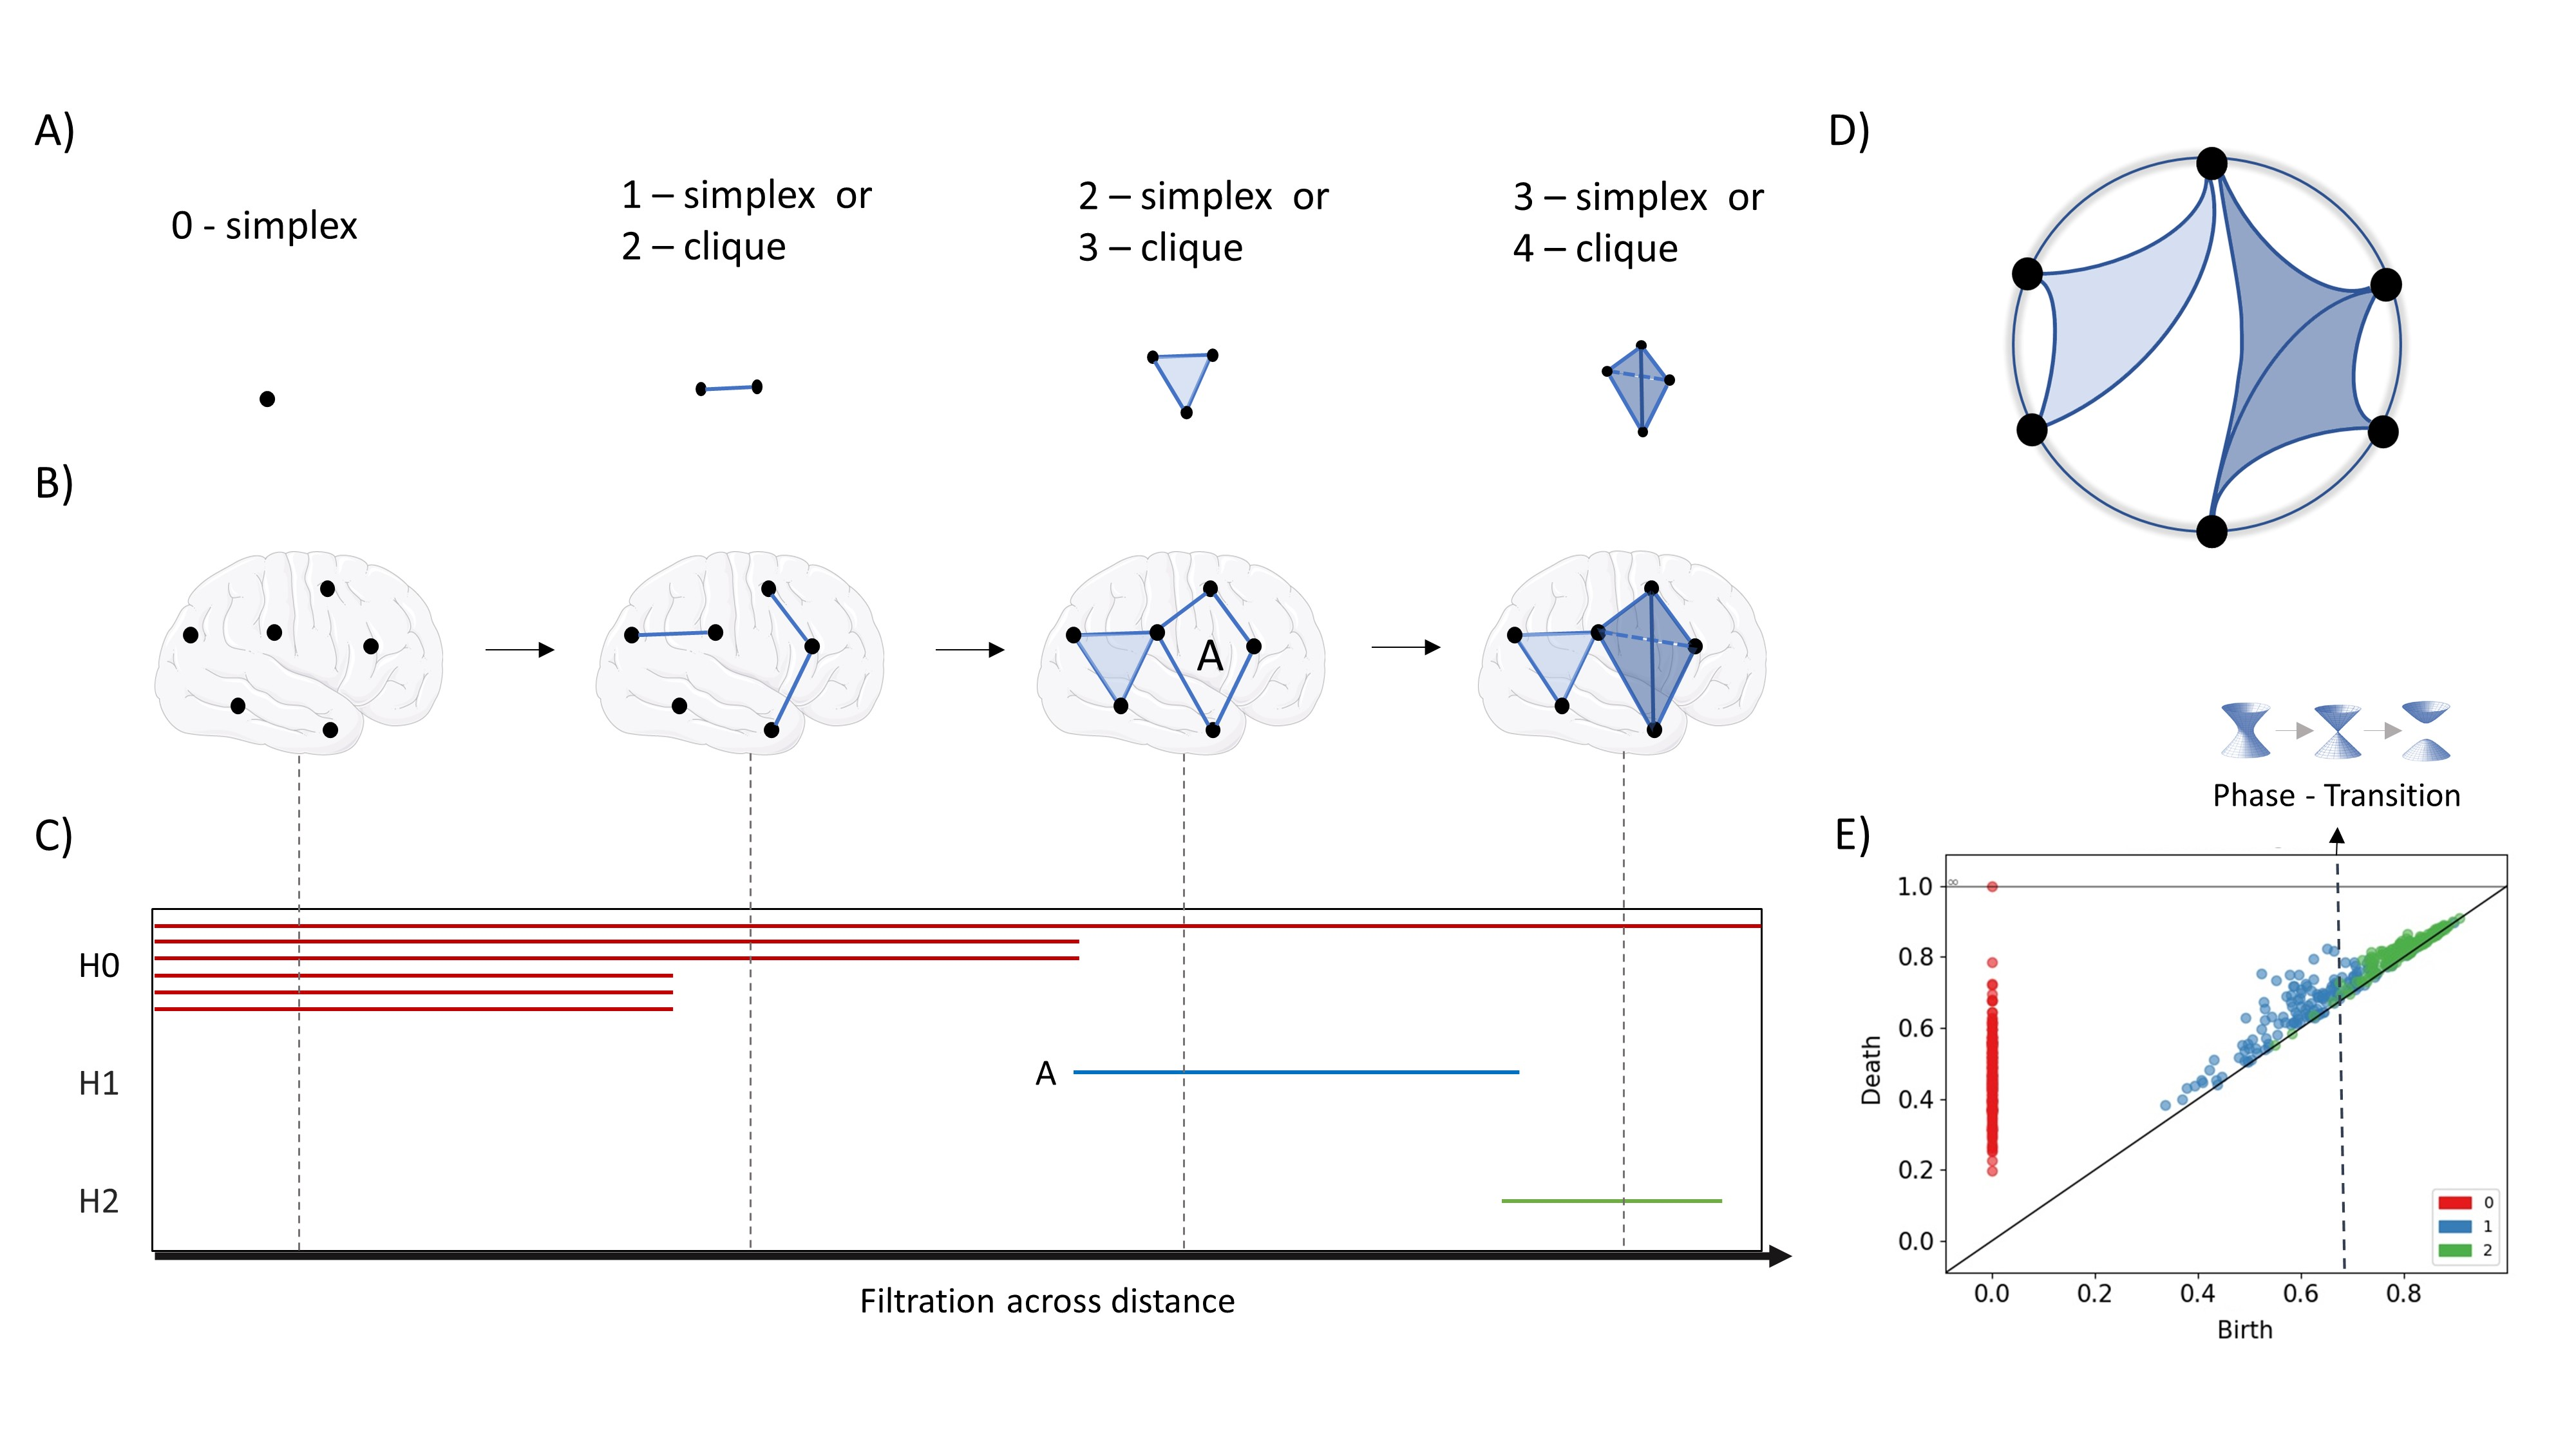
Figure 3. Topological data analysis. (A) Illustration of simplexes. (B) Representation of simplexes/cliques of different order being formed in the brain across the filtration process. (C) Barcode respective to panel B, representing the filtration across distances (i.e., the inverse of weights in a correlation matrix). Line A represents cycle A in B. H0-2 indicates the homology groups. (H0 = connected components, H1 = one-dimensional holes, H2 = 2-dimensional holes). (D) Circular projection of how the brain would be connected. (E) Persistence diagram (or Birth/Death plot) obtained from real rsfMRI brain data. In this plot, it is also possible to identify a phase transition between H1 and H2.

In [ ]:
# Computation of persistence barcode  (http://gudhi.gforge.inria.fr/python/latest/persistence_graphical_tools_user.html)

# Converting to distance matrix
mattop = 1 - matrix

# Computing and plotting barcode
rips_complex = gudhi.RipsComplex(distance_matrix=mattop, max_edge_length=1)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
diag = simplex_tree.persistence()
gudhi.plot_persistence_barcode(diag, legend=True, max_intervals=0)

In [ ]:
# Persistence Diagram 
gudhi.plot_persistence_diagram(diag, legend=True, max_intervals=0)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Birth', fontsize=15)
plt.ylabel('Death', fontsize=15)

In [ ]:
# Persistence density plots
gudhi.plot_persistence_density(diag, dimension=1)

#####  Betti numbers
Another set of topological invariants are the Betti numbers (𝛽). Given that a simplicial complex is a high-dimensional structure, 𝛽𝑘 counts the number of k-dimensional holes in the simplicial complex. These are topological invariants that cor-respond, for each 𝑘≥0, to the number of linearly independent k-dimensional holes in the simplicial complex.

In [ ]:
# Import TDA functions
%run "./Background Scripts/TDA.py"

In [ ]:
# Compute a sparser graph (10%)
G_d10 = densthr(0.1, matrix)

# Compute Betti number
Betti_k(G_d10, 1)

#####  Computation of phase transitions and curvature

One way of connecting the geometry of a continuous surface to its topology is by using local curvature and Euler characteristics. Here, we will compute the network curvature at each node to calculate topological phase transitions in brain networks from a local perspective (Reference [6]). Here we will show the computation for both threshold-based and density-based filtration.

In [ ]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation threshold level.
plotEuler_thr(matrix, 70)

In [ ]:
# Euler entropy (Sχ = ln|χ|) as a function of the correlation density level.
plotEuler_den(matrix, 20)

#####  Now, we can obtain the value of curvature for each node at a specific threshold, and then save as a dict with the region name abbreviations.

In [ ]:
# Obtaining the value of curvature for each node at a specific threshold and creating a dictionary with brain region names.
curvalues = Curv_thr(i=matrix, e=0.7)
dict(zip(lineList, curvalues))

In [ ]:
# Histogram for curvature distribution at a specific threshold.
sns.distplot(curvalues, kde=False, norm_hist=False)
plt.xlabel('Curvature Values')
plt.ylabel('Counts')

In [ ]:
# Obtaining the value of curvature for each node at a specific density and creating a dictionary with brain region names.
curvals_den = Curv_density(i=matrix, d=0.15)
#dict(zip(lineList, curvals_den))

In [ ]:
# Histogram for curvature distribution at a specific density.
sns.distplot(curvals_den, kde=False, norm_hist=False)
plt.xlabel('Curvature Values')
plt.ylabel('Counts')

<a id='references'></a>

## **5.** References

[1] Brown JA, Rudie JD, Bandrowski A, Van Horn JD, Bookheimer SY. The UCLA multimodal connectivity database: a web-based platform for brain connectivity matrix sharing and analysis. Front Neuroinform. 2012;6:28. doi: 10.3389/fninf.2012.00028.

[2] Biswal BB, Mennes M, Zuo XN, Gohel S, Kelly C, Smith SM, et al. Toward discovery science of human brain function. Proc Natl Acad Sci U S A. 2010;107(10):4734-9. doi: 10.1073/pnas.0911855107.

[3] Fornito A, Zalesky A, Bullmore E. Fundamentals of brain network analysis. 1st ed. San Diego: Academic Press; 2016.

[4] Hagberg A, Swart P, S Chult D, editors. Exploring network structure, dynamics, and function using NetworkX. Proceedings of the 7th Python in Science conference (SciPy 2008); 2008 Aug 19-24; Pasadena, USA.

[5] Bassett DS, Sporns O. Network neuroscience. Nat Neurosci. 2017;20(3):353. doi: 10.1038/nn.4502.

[6] Santos FAN, Raposo EP, Coutinho-Filho MD, Copelli M, Stam CJ, Douw L. Topological phase transitions in functional brain networks. Phys Rev E. 2019;100(3-1):032414. doi: 10.1103/PhysRevE.100.032414.

<a id='acknowledgements'></a>

## **6.** Acknowledgements

The 1000_Functional_Connectomes dataset was downloaded from the [The UCLA multimodal connectivity database](http://umcd.humanconnectomeproject.org/).